In [185]:
import json
import os
import re
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from itertools import zip_longest
import numpy as np

In [186]:
# minimum columns

ra_dec_files_to_load = ["/jet/home/mcguires/lsdb/benchmark_results/2025-02-04_00-47-22", "/jet/home/mcguires/lsdb/benchmark_results/2025-02-04_01-03-11", "/jet/home/mcguires/lsdb/benchmark_results/2025-02-04_01-20-06", "/jet/home/mcguires/lsdb/benchmark_results/2025-02-05_16-24-09"]

# all columns

all_cols_files_to_load = ["/jet/home/mcguires/lsdb/benchmark_results/2025-02-04_23-26-03", "/jet/home/mcguires/lsdb/benchmark_results/2025-02-04_18-46-41", "/jet/home/mcguires/lsdb/benchmark_results/2025-02-04_03-55-21", "/jet/home/mcguires/lsdb/benchmark_results/2025-02-04_18-18-57", "/jet/home/mcguires/lsdb/benchmark_results/2025-02-05_13-18-42", "/jet/home/mcguires/lsdb/benchmark_results/2025-02-05_13-30-35"]

In [187]:
def get_plot_arrays(files_to_load):

    results = defaultdict(list)
    measurements = {}
    for result_dir in files_to_load:  # Replace with your actual directory path
        files = os.listdir(result_dir)
        pattern = re.compile("^run_([0-9])\.json")
        filtered_files = [f for f in files if pattern.match(f)]
        for f in filtered_files:
            with open(os.path.join(result_dir, f), "r") as fp:
                measurements[os.path.join(result_dir, f)] = json.load(fp)
                
    for res in measurements.values():
        for nparts, filter_ms in res.items():
            if not nparts == "settings":
                total_ms = filter_ms.values() if list(filter_ms.keys())[0].isnumeric() else [filter_ms]
                for ms in total_ms:
                    for nworkers, lsdb_ms in ms.pop("lsdb").items():
                        for k, v in lsdb_ms.items():
                            results[f"{k}_{nworkers}"].append((v["time"], v["result_length"]))
                    for k, v in ms.items():
                        results[k].append((v["time"], v["result_length"]))
            
    
    plot_arrays = {}
    for k, v in results.items():
        length_times = defaultdict(list)
        for t, l in v:
            length_times[l].append(t)
        plot_arrays[k] = [(np.nanmedian(ts), l, np.nanquantile(ts, [0.1, 0.9])) for l, ts in length_times.items()]
    
    for arr in plot_arrays:
        plot_arrays[arr] = sorted(plot_arrays[arr], key=lambda x: x[1])
    return plot_arrays

plot_arrays = get_plot_arrays(all_cols_files_to_load)

plot_arrays["total_sequential_io"] = [(plot_arrays["ztf_pyarrow"][0][0] + plot_arrays["gaia_pyarrow"][0][0] + plot_arrays["gaia_margin_pyarrow"][0][0], plot_arrays["astropy_xmatch"][0][1], plot_arrays["ztf_pyarrow"][0][2] + plot_arrays["gaia_pyarrow"][0][2] + plot_arrays["gaia_margin_pyarrow"][0][2])] * 3 + [(z[0] + g[0] + gm[0], ax[1], z[2] + g[2] + gm[2]) for z, g, gm, ax in zip(plot_arrays["ztf_pyarrow"], plot_arrays["gaia_pyarrow"], plot_arrays["gaia_margin_pyarrow"], plot_arrays["astropy_xmatch"][2:])]
plot_arrays["total_dask_io"] = [(io[0], x[1], io[2]) for io, x in zip(plot_arrays["total_dask_16"], plot_arrays["lsdb_crossmatch_16"])]
plot_arrays["total_io"] = [(min(s[0], d[0]), d[1],[s[2], d[2]][np.argmin([s[0], d[0]])]) for s, d in zip_longest(plot_arrays["total_sequential_io"], plot_arrays["total_dask_io"], fillvalue=(1000000, 0, 0))]

plot_arrays["astropy+io"] = [(io[0] + ax[0], ax[1], io[2] + ax[2]) for io, ax in zip(plot_arrays["total_sequential_io"], plot_arrays["astropy_xmatch"])]

In [188]:
ra_dec_plot_arrays = get_plot_arrays(ra_dec_files_to_load)
ra_dec_plot_arrays["total_sequential_io"] = [(ra_dec_plot_arrays["ztf_pyarrow"][0][0] + ra_dec_plot_arrays["gaia_pyarrow"][0][0] + ra_dec_plot_arrays["gaia_margin_pyarrow"][0][0], ra_dec_plot_arrays["astropy_xmatch"][0][1], ra_dec_plot_arrays["ztf_pyarrow"][0][2] + ra_dec_plot_arrays["gaia_pyarrow"][0][2] + ra_dec_plot_arrays["gaia_margin_pyarrow"][0][2])] * 3 + [(z[0] + g[0] + gm[0], ax[1], z[2] + g[2] + gm[2]) for z, g, gm, ax in zip(ra_dec_plot_arrays["ztf_pyarrow"], ra_dec_plot_arrays["gaia_pyarrow"], ra_dec_plot_arrays["gaia_margin_pyarrow"], ra_dec_plot_arrays["astropy_xmatch"][2:])]

ra_dec_plot_arrays["astropy+io"] = [(io[0] + ax[0], ax[1], io[2] + ax[2]) for io, ax in zip(ra_dec_plot_arrays["total_sequential_io"], ra_dec_plot_arrays["astropy_xmatch"])]
plot_arrays["lsdb_crossmatch_16_ra_dec"] = ra_dec_plot_arrays["lsdb_crossmatch_16"]
plot_arrays["astropy_ra_dec"] = ra_dec_plot_arrays["astropy+io"]

In [189]:
smatch_result_path = "/ocean/projects/phy210048p/malanche/lsdb-xmatch-perf/bench_data"
smatch_all_files = os.listdir(smatch_result_path)
pattern = re.compile("^smatch.*\.json")
smatch_files = [f for f in smatch_all_files if pattern.match(f)]

smatch_measurements = {}

for file in smatch_files:
    with open(os.path.join(smatch_result_path, file), "r") as fp:
        smatch_measurements[os.path.join(smatch_result_path, file)] = json.load(fp)["measurements"]

smatch_results = defaultdict(list)

for res in smatch_measurements.values():
    for k, v in res.items():
        smatch_results[k].append((v["time"], v["result_length"]))

smatch_plot_arrays = {}
for k, v in smatch_results.items():
    length_times = defaultdict(list)
    for t, l in v:
        length_times[l].append(t)
    smatch_plot_arrays[k] = [(np.nanmedian(ts), l, np.nanquantile(ts, [0.1, 0.9])) for l, ts in length_times.items()]

for arr in smatch_plot_arrays:
    smatch_plot_arrays[arr] = sorted(smatch_plot_arrays[arr], key=lambda x: x[1])

plot_arrays["smatch"] = smatch_plot_arrays["smatch"][:-1]
smatch_io = [(plot_arrays["ztf_pyarrow"][0][0] + plot_arrays["gaia_pyarrow"][0][0] + plot_arrays["gaia_margin_pyarrow"][0][0], plot_arrays["astropy_xmatch"][0][1], plot_arrays["ztf_pyarrow"][0][2] + plot_arrays["gaia_pyarrow"][0][2] + plot_arrays["gaia_margin_pyarrow"][0][2])] * 2 + [(z[0] + g[0] + gm[0], ax[1], z[2] + g[2] + gm[2]) for z, g, gm, ax in zip(plot_arrays["ztf_pyarrow"], plot_arrays["gaia_pyarrow"], plot_arrays["gaia_margin_pyarrow"], plot_arrays["astropy_xmatch"][2:])]
plot_arrays["smatch+io"] = [(io[0] + ax[0], ax[1], io[2] + ax[2]) for io, ax in zip(smatch_io, plot_arrays["smatch"])]

In [190]:
len(plot_arrays["smatch+io"])

4

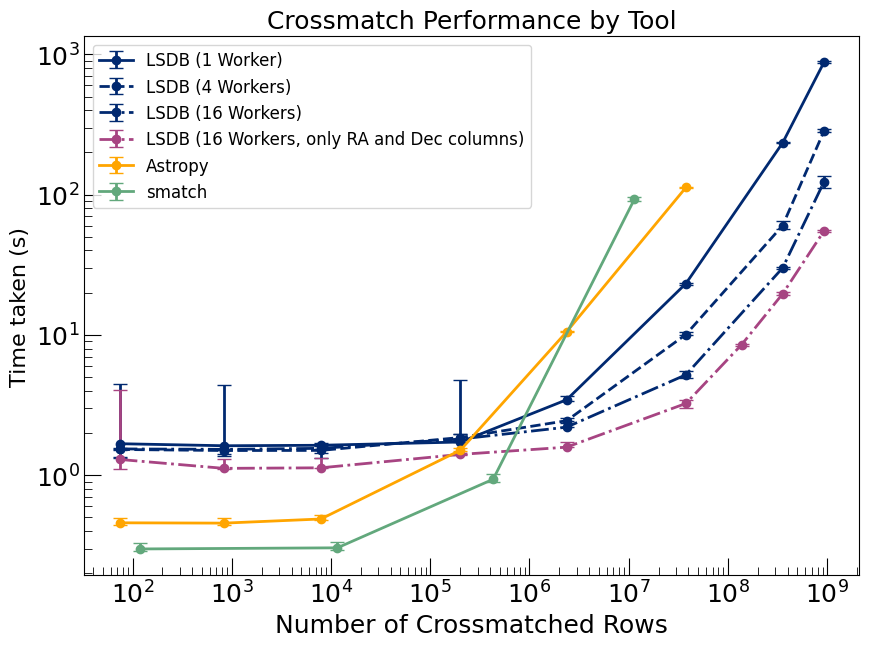

In [191]:
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plotting_args = {
    "lsdb_crossmatch_1": {"marker": "o", "label": "LSDB (1 Worker)", "c": "#012970", "ls": '-', "lw": 2}, 
    "lsdb_crossmatch_4": {"marker": "o", "label": "LSDB (4 Workers)", "c": "#012970", "ls": '--', "lw": 2}, 
    "lsdb_crossmatch_16": {"marker": "o", "label": "LSDB (16 Workers)", "c": "#012970", "ls": '-.', "lw": 2}, 
    "lsdb_crossmatch_16_ra_dec": {"marker": "o", "label": "LSDB (16 Workers, only RA and Dec columns)", "c": "#A74482", "ls": '-.', "lw": 2}, 
    "astropy+io": {"marker": "o", "label": "Astropy", "c": "orange", "lw": 2}, 
    # "astropy_ra_dec": {"marker": "x", "label": "Astropy (only RA and Dec columns)", "c": "#E59927", "lw": 2}, 
    "smatch+io": {"marker": "o", "label": "smatch", "c": "#62A87C", "ls": '-', "lw": 2}, 
    # "total_io": {"marker": "x", "label": "I/O Read", "c": "#63993D", "lw": 2},
}
for k, p_args in plotting_args.items():
    if k in plot_arrays:
        v = plot_arrays[k]
        ax.errorbar([int(i[1]) for i in v], [i[0] for i in v], [[i[0] - i[2][0] for i in v], [i[2][1] - i[0] for i in v]], capsize=5, **plotting_args[k])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=18, length=12, direction="in")
ax.tick_params(axis='both', which='minor', labelsize=12, length=6, direction="in")
plt.xlabel("Number of Crossmatched Rows", fontsize=18)
plt.ylabel("Time taken (s)", fontsize=16)
plt.title("Crossmatch Performance by Tool", fontsize=18)
plt.legend(fontsize=12)